In [6]:
import numpy as np 
import pandas as pd 
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
from keras_facenet import FaceNet
from sklearn.externals import joblib

facenet_model = FaceNet()


See a sample image

1/1 [==============================] - 0s 152ms/step


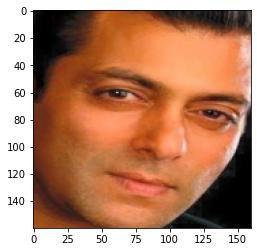

(160, 160, 3)


In [8]:
def face_crop(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = face_crop('data/train/Selmon Bhai/salmankhan.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

Apply face_crop() for all faces in the dataset

In [9]:
def load_image_paths(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = face_crop(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_image_paths(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('data/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('compressed_dataset.npz', trainX, trainy, testX, testy)
        

1/1 [==============================] - 0s 128ms/step
loaded 5 sample for class: Ayaan
1/1 [==============================] - 0s 157ms/step
loaded 5 sample for class: ben_afflek
1/1 [==============================] - 0s 141ms/step
loaded 5 sample for class: elton_john
1/1 [==============================] - 0s 135ms/step
loaded 5 sample for class: jerry_seinfeld
1/1 [==============================] - 0s 129ms/step
loaded 5 sample for class: madonna
1/1 [==============================] - 0s 133ms/step
loaded 5 sample for class: mindy_kaling
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 129ms/step
loaded 5 sample for class: Raghav
1/1 [==============================] - 0s 131ms/step
loaded 5 sample for class: Selmon Bhai
1/1 [==============================] - 0s 129ms/step
loaded 5 sample for class: SRK
1/1 [==============================] - 0s 373ms/step
loaded 5 sample for class: The Mask
(50, 160, 160, 3) (50,)
1/1 [==============================] - 0s 165ms/step
loaded 5 sample for class: Ayaan
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 176ms/step
loaded 14 sample for class: ben_afflek
1/1 [==============================] - 0s 166ms/step
loaded 17 sample for class: elton_john
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 168ms/step
loaded 21 sample for class: jerry_seinfeld
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 165ms/step
loaded 19 sample for class: madonna
1/1 [==============================] - 0s 141ms/step
loaded 22 sample for class: mindy_kaling
1/1 [==============================] - 0s 131ms/step
loaded 5 sample for class: Raghav
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 151ms/step
loaded 23 sample for class: Selmon Bhai
1/1 [==============================] - 0s 168ms/step
loaded 17 sample for class: SRK
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 171ms/step
loaded 12 sample for class: The Mask
(155, 160, 160, 3) (155,)


In [12]:
# load the face dataset
data = np.load('compressed_dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (50, 160, 160, 3) (50,) (155, 160, 160, 3) (155,)


In [14]:
def extract_embeddings(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
#     mean, std = face.mean(), face.std()
#     face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = extract_embeddings(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = extract_embeddings(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('compressed_embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 73ms/step
(50, 512)
1/1 [==============================] - 0s 85ms/step
(155, 512)


In [15]:


print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=50, test=155
Accuracy: train=100.000, test=99.355


Randomly select a face from test set for prediction. Calculate confidence

Predicted: 
['Ayaan' 'Raghav' 'SRK' 'Selmon Bhai' 'The Mask'] 
[ 6.82268018  2.53952781  4.85288976  4.69923158  7.44349112  8.65440355
  4.77999817 48.85131881  6.30487689  5.05158212]
Expected: jerry_seinfeld


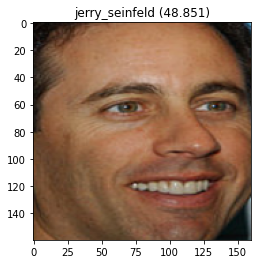

In [63]:

# select a random face from test set
c = choice([i for i in range(testX.shape[0])])
rand_test = testX[c]
rand_test_emd = emdTestX_norm[c]
rand_test_class = testy_enc[c]
rand_test_name = out_encoder.inverse_transform([rand_test_class])

# prediction for the face
samples = np.expand_dims(rand_test_emd, axis=0)
yhat_class = model.predict(samples)

yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % rand_test_name[0])
# plot face
plt.imshow(rand_test)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
